# Multi Agent Architecture
- Combining different Agent Together

### Lets start with combinig Subgraphs together

### Subgraph 1

In [11]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END
from langchain_groq import ChatGroq 
from langchain_core.messages import AIMessage, HumanMessage
from dotenv import load_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from langgraph.prebuilt import ToolNode

load_dotenv()

True

#### subgraph1 nodes

In [17]:
class ChildState(TypedDict):
    messages: Annotated[list, add_messages]

search_tool  = TavilySearchResults(max_results=2)
tools = [search_tool]

# llm = ChatGroq(model="llama3-8b-8192")   # 8b model  - faster model
llm = ChatGroq(model="llama3-70b-8192")  # 70b model  x8 better but slower

llm_with_tools = llm.bind_tools(tools=tools)

def agent(state:ChildState):
    return {
        "messages":[llm_with_tools.invoke(state["messages"])]
    }

def tools_router(state:ChildState):
    last_message = state["messages"][-1]

    if (hasattr(last_message, "tool_calls") and len(last_message.tool_calls) > 0) :
        return "tools"
    else:
        return "stop"

tool_node = ToolNode(tools=tools)



#### Subgraph1 Graph

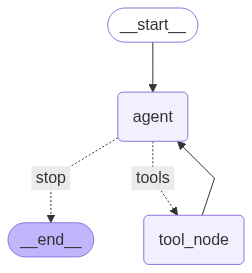

In [18]:
subgraph = StateGraph(ChildState)

subgraph.add_node("agent", agent)
subgraph.add_node("tool_node", tool_node)
subgraph.set_entry_point("agent")

subgraph.add_conditional_edges("agent", tools_router, { "tools":"tool_node", "stop":END})
subgraph.add_edge("tool_node", "agent")

search_app = subgraph.compile()
search_app

In [ ]:
result = search_app.invoke({
    "messages":[HumanMessage(content="What is the temperature in Abuja today")]
})

print(result)

print("=====ANSWER=======")
print(result["messages"][-1].content)

### Lets create another graph which will search as the parent graph to this subgraph. We will then link subgraph1 to parent graph
- this parent graph as the same schema structure as the subgraph

In [23]:
from typing import TypedDict, Annotated
from langgraph.graph import add_messages, StateGraph, END, START
from langchain_groq import ChatGroq 
from langchain_core.messages import HumanMessage
 

load_dotenv()

True

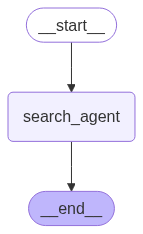

In [25]:
class ParentState(TypedDict):
    messages: Annotated[list, add_messages]

parent_graph = StateGraph(ParentState)

#add the subgraph to a node
parent_graph.add_node("search_agent", search_app)

#connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent",END)

parent_app = parent_graph.compile()

parent_app



In [28]:
result = parent_app.invoke({
   "messages": [HumanMessage(content="what is the weather in Abuja today")]
})
print(result["messages"][-1].content)

The current weather in Abuja is partly cloudy with a temperature of 23°C, humidity of 90%, and wind speed of 5.4 kmph from the SSW direction. Visibility is 10 km.


# lets link it with another graph but this time it has different schema definition

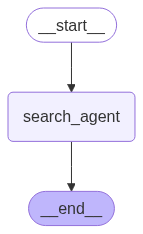

In [36]:
from typing import Dict

class QueryState(TypedDict):
    query: str
    response: str

#Function to invok subgraph
def search_agent(state:QueryState) ->Dict:
    # Transform from parent schema to subgraph schema
    subgraph_input = {
        "messages" : [HumanMessage(content=state["query"])]
    }

    #Invoke the subgraph
    subgraph_result = search_app.invoke(subgraph_input)
    #Transform response back to parent schema
    assistant_message = subgraph_result["messages"][-1]
    return {"response":assistant_message.content}


#create the parent graph

parent_graph = StateGraph(QueryState)

# add transfomraiton node that invokes subgraph
parent_graph.add_node("search_agent",search_agent)

#connect the flow
parent_graph.add_edge(START, "search_agent")
parent_graph.add_edge("search_agent", END)

parent_app = parent_graph.compile()
parent_app

In [38]:
result = parent_app.invoke({"query":"How is the weather in Lagos, Nigeria?"})

print(result["response"])

The weather in Lagos, Nigeria is expected to be patchy rain possible with average temperatures of 28°C / 25°C in July.
